In [3]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from tqdm import tqdm
from copy import deepcopy
from collections import defaultdict
from typing import Dict, List, Tuple, Iterable, Optional
import pickle
import ast
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["font.family"] = "Lato"
rcParams["font.size"] = 16
rcParams['text.color'] = '#3F3F3F'
rcParams['axes.labelcolor'] = '#3F3F3F'
rcParams['xtick.color'] = '#3F3F3F'
rcParams['ytick.color'] = '#3F3F3F'
TEAL = ["#b5d1ae", "#80ae9a", "#568b87", "#326b77", "#1b485e", "#122740"]

FEATURES = ["length","is_assembled","ap","has_beta_sheet_content","hydrophobic_moment","net_charge"]
COUNT_FEATURES = FEATURES
MORPH_FEATURES = ["has_beta_sheet_content","hydrophobic_moment","net_charge"]

from classifier.models import PeptidePredictor
from cvae.models import CVAESimpleEnc
from cvae.utils import (
    CONDITION_LENGTH, MAX_SEQ_LENGTH, MAX_FASTA_LENGTH, ALPHABET, PAD_TOKEN_ID, EOS_ID, BOS_ID, idx_to_fasta, esm_model_pretrained, convert_and_pad
)

try:
    import editdistance
except ImportError:
    editdistance = None

try:
    from numba import njit
    NUMBA_AVAILABLE = True
except Exception:
    NUMBA_AVAILABLE = False

LENGTHS = list(range(5, 11))
RNG = np.random.default_rng(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, torch.cuda.device_count())

cuda 1


In [5]:
batch_size = 2048
df = pd.read_csv("../../clean_data/merged_all.csv", keep_default_na=False, na_values=[''])
train_val_df, test_df = train_test_split(df, test_size=0.1, stratify=df['length'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, stratify=train_val_df['length'], random_state=42)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, torch.cuda.device_count())

cvae_model = CVAESimpleEnc(
    encoder_hidden_dim=256,
    num_encoder_layers=2,
    vocab_size=len(ALPHABET),
    latent_dim=24,
    cond_dim=CONDITION_LENGTH,
    max_seq_length=MAX_SEQ_LENGTH,
    decoder_hidden_dim=256,
    num_decoder_layers=2,
    nhead=8,
    dropout=0.1)

pretrained_state_dict = torch.load("../cvae/chkpts/finetuned_cvae.pt", map_location=device, weights_only=True)
cvae_model.load_state_dict(pretrained_state_dict)

cuda 1


<All keys matched successfully>

In [7]:
cvae_model.eval()

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    cvae_model = nn.DataParallel(cvae_model)

cvae_model.to(device)
print("CVAE initialized with finetuned architecture")

CVAE initialized with finetuned architecture


In [8]:
def to_fasta(tokens):
    fasta = ''
    for token in tokens:
        if token == 2:
            break
        if token in [0, 1, 3, 29, 30, 31, 32]:
            continue
        else:
            fasta += idx_to_fasta[token]
    return fasta    

In [ ]:
FEATURES = ["length","is_assembled","ap","has_beta_sheet_content","hydrophobic_moment","net_charge"]
FEATURES_ALL = FEATURES
COND_FEATURES = ["is_assembled","ap","has_beta_sheet_content","hydrophobic_moment","net_charge"]
AMINO_ALPHABET = "ACDEFGHIKLMNPQRSTVWY"
AA_TO_INT = {aa:i for i,aa in enumerate(AMINO_ALPHABET)}
PAD_VAL = -1

def encode_seq(s: str) -> np.ndarray:
    return np.array([AA_TO_INT.get(ch, len(AMINO_ALPHABET)-1) for ch in s], dtype=np.int8)

def encode_pad_sequences(seqs):
    """Return (codes[N, Lmax] int16, lens[N] int16) padded with PAD_VAL."""
    lens = np.array([len(s) for s in seqs], dtype=np.int16)
    Lmax = int(lens.max()) if len(lens) else 0
    codes = np.full((len(seqs), Lmax), PAD_VAL, dtype=np.int16)
    for i, s in enumerate(seqs):
        for j, ch in enumerate(s):
            codes[i, j] = AA_TO_INT.get(ch, len(AMINO_ALPHABET)-1)
    return codes, lens

In [ ]:
# Needleman–Wunsch % identity (global)
if NUMBA_AVAILABLE:
    @njit(cache=True, fastmath=True)
    def nw_identity_counts(a_codes: np.ndarray, b_codes: np.ndarray) -> Tuple[int,int]:
        na, nb = a_codes.size, b_codes.size
        score = np.empty((na+1, nb+1), dtype=np.int16)
        match = np.zeros((na+1, nb+1), dtype=np.int16)
        alen  = np.zeros((na+1, nb+1), dtype=np.int16)

        gap = -1
        score[0,0] = 0
        for i in range(1, na+1):
            score[i,0] = score[i-1,0] + gap
            match[i,0] = 0
            alen[i,0]  = i
        for j in range(1, nb+1):
            score[0,j] = score[0,j-1] + gap
            match[0,j] = 0
            alen[0,j]  = j

        for i in range(1, na+1):
            ai = a_codes[i-1]
            for j in range(1, nb+1):
                bj = b_codes[j-1]
                sc_diag = score[i-1,j-1] + (1 if ai==bj else 0)
                mt_diag = match[i-1,j-1] + (1 if ai==bj else 0)
                ln_diag = alen[i-1,j-1] + 1

                sc_up = score[i-1,j] + gap
                mt_up = match[i-1,j]
                ln_up = alen[i-1,j] + 1

                sc_left = score[i,j-1] + gap
                mt_left = match[i,j-1]
                ln_left = alen[i,j-1] + 1

                # choose best by (score, matches, -alen)
                sc = sc_diag; mt = mt_diag; ln = ln_diag

                if (sc_up > sc) or (sc_up == sc and (mt_up > mt or (mt_up == mt and ln_up < ln))):
                    sc = sc_up; mt = mt_up; ln = ln_up

                if (sc_left > sc) or (sc_left == sc and (mt_left > mt or (mt_left == mt and ln_left < ln))):
                    sc = sc_left; mt = mt_left; ln = ln_left

                score[i,j] = sc; match[i,j] = mt; alen[i,j] = ln

        return int(match[na,nb]), int(alen[na,nb])

else:
    def nw_identity_counts(a_codes: np.ndarray, b_codes: np.ndarray) -> Tuple[int,int]:
        na, nb = a_codes.size, b_codes.size
        gap = -1

        score = [[0]*(nb+1) for _ in range(na+1)]
        match = [[0]*(nb+1) for _ in range(na+1)]
        alen  = [[0]*(nb+1) for _ in range(na+1)]

        for i in range(1, na+1):
            score[i][0] = score[i-1][0] + gap
            alen[i][0]  = i
        for j in range(1, nb+1):
            score[0][j] = score[0][j-1] + gap
            alen[0][j]  = j

        for i in range(1, na+1):
            ai = a_codes[i-1]
            for j in range(1, nb+1):
                bj = b_codes[j-1]
                sc_diag = score[i-1][j-1] + (1 if ai==bj else 0)
                mt_diag = match[i-1][j-1] + (1 if ai==bj else 0)
                ln_diag = alen[i-1][j-1] + 1

                sc_up = score[i-1][j] + gap
                mt_up = match[i-1][j]
                ln_up = alen[i-1][j] + 1

                sc_left = score[i][j-1] + gap
                mt_left = match[i][j-1]
                ln_left = alen[i][j-1] + 1

                sc = sc_diag; mt = mt_diag; ln = ln_diag
                if (sc_up > sc) or (sc_up == sc and (mt_up > mt or (mt_up == mt and ln_up < ln))):
                    sc = sc_up; mt = mt_up; ln = ln_up
                if (sc_left > sc) or (sc_left == sc and (mt_left > mt or (mt_left == mt and ln_left < ln))):
                    sc = sc_left; mt = mt_left; ln = ln_left

                score[i][j] = sc; match[i][j] = mt; alen[i][j] = ln

        return match[na][nb], alen[na][nb]

def nw_percent_identity(a: str, b: str) -> float:
    ac, bc = encode_seq(a), encode_seq(b)
    m, L = nw_identity_counts(ac, bc)
    return 1.0 if L == 0 else (m / L)

In [ ]:
def normalized_edit_dist(a: str, b: str) -> float:
    d = editdistance.eval(a, b)
    return d / max(len(a), len(b), 1)

In [ ]:
def _even_counts_over_k(n_total: int, k_min: int = 1, k_max: int = 6, rng: np.random.RandomState = np.random.RandomState(0)) -> Dict[int,int]:
    """
    Evenly split n_total over k in [k_min..k_max]. Any remainder is assigned randomly.
    Returns {k_used: count}.
    """
    Ks = list(range(k_min, k_max+1))
    base = n_total // len(Ks)
    rem  = n_total % len(Ks)
    counts = {k: base for k in Ks}
    if rem > 0:
        bump = rng.choice(Ks, size=rem, replace=False)
        for k in bump:
            counts[k] += 1
    return counts

def _random_k_subsets(features: List[str], k_list: List[int], rng: np.random.RandomState) -> List[List[str]]:
    """For each k in k_list, sample a random k-subset of `features` (without replacement)."""
    out = []
    for k in k_list:
        out.append(rng.choice(features, size=k, replace=False).tolist())
    return out

In [ ]:
COND_FEATURES = ["is_assembled","ap","has_beta_sheet_content","hydrophobic_moment","net_charge"]

def fit_gmm_per_length(train_df: pd.DataFrame,
                       lengths: Iterable[int],
                       n_components: int = 5,
                       random_state: int = 42):
    """Fit per-length imputers, scalers, and GMMs on descriptor space (excl. length)."""
    models = {}
    for L in lengths:
        dfL = train_df.loc[train_df["length"] == L, COND_FEATURES].copy()
        if dfL.empty:
            raise ValueError(f"No training rows for length={L}")
        num_cols = ["ap","hydrophobic_moment","net_charge"]
        bin_cols = ["is_assembled","has_beta_sheet_content"]
        ct = ColumnTransformer([
            ("num", SimpleImputer(strategy="median"), num_cols),
            ("bin", SimpleImputer(strategy="most_frequent"), bin_cols),
        ])
        X_imp = ct.fit_transform(dfL)

        scaler = MinMaxScaler((0,1))
        X_scaled = scaler.fit_transform(X_imp)

        gmm = GaussianMixture(n_components=n_components, covariance_type="full",
                              random_state=random_state)
        gmm.fit(X_scaled)
        models[L] = {"imputer": ct, "scaler": scaler, "gmm": gmm,
                     "num_cols": num_cols, "bin_cols": bin_cols}
    return models

def sample_in_distribution_conditions(models: Dict[int,dict],
                                      per_length_counts: Dict[int,int],
                                      rng: np.random.RandomState = np.random.RandomState(0),
                                      global_even_k: bool = True) -> List[dict]:
    """
    For each length L, draw per_length_counts[L] GMM samples.
    If global_even_k=True, split ALL those samples evenly over k∈{1..6}; otherwise do per-length.
    """
    conds = []

    perL_params = {}
    for L, count in per_length_counts.items():
        pack = models[L]
        gmm, scaler = pack["gmm"], pack["scaler"]
        num, binf   = pack["num_cols"], pack["bin_cols"]

        Xs, _ = gmm.sample(count)
        X_imp = scaler.inverse_transform(np.clip(Xs, 0, 1))

        params_list = []
        for row in X_imp:
            row = np.clip(row, 0, None)
            vals = {}
            off = 0
            for i, c in enumerate(num):
                vals[c] = float(row[off+i])
            off += len(num)
            for i, c in enumerate(binf):
                vals[c] = float(1.0 if row[off+i] >= 0.5 else 0.0)
            vals_full = {"length": int(L)}
            vals_full.update(vals)
            params_list.append(vals_full)

        perL_params[L] = params_list

    Ks = list(range(1, 7))
    total = sum(len(v) for v in perL_params.values())

    def _even_counts_over_k(n_total: int) -> dict:
        base = n_total // len(Ks)
        rem  = n_total %  len(Ks)
        counts = {k: base for k in Ks}
        if rem > 0:
            for i in range(rem):
                counts[Ks[i]] += 1
        return counts

    counts_by_k = _even_counts_over_k(total)
    k_list = []
    for k in Ks:
        k_list += [k]*counts_by_k[k]
    rng.shuffle(k_list)

    ptr = 0
    for L in sorted(perL_params.keys()):
        params_list = perL_params[L]
        k_slice = k_list[ptr:ptr+len(params_list)]
        ptr += len(params_list)

        used_subsets = _random_k_subsets(FEATURES_ALL, k_slice, rng)
        for row_params, used_feats in zip(params_list, used_subsets):
            conds.append({
                "params": row_params,
                "length": L,
                "used_features": used_feats,
                "ood_type": "in_dist",
            })

    return conds

def compute_rare_values(train_df: pd.DataFrame, L: int) -> dict:
    """Pick rare values for has_beta_sheet_content (least frequent class) and
       rare extreme for hydrophobic_moment (min/max depending on rarity)."""
    dfL = train_df.loc[train_df["length"] == L]
    freq = dfL["has_beta_sheet_content"].value_counts(dropna=True)
    if len(freq) == 0:
        rare_beta = 1.0
    else:
        rare_beta = float(freq.idxmin())
    # extreme
    q05, q95 = dfL["hydrophobic_moment"].quantile(0.05), dfL["hydrophobic_moment"].quantile(0.95)
    tail_low = (dfL["hydrophobic_moment"] <= q05).sum()
    tail_high = (dfL["hydrophobic_moment"] >= q95).sum()
    rare_hm = float(q05 if tail_low < tail_high else q95)
    print(f"Length {L}: rare beta={rare_beta}, rare hm={rare_hm} (tails {tail_low}/{tail_high})")
    return {"has_beta_sheet_content": rare_beta, "hydrophobic_moment": rare_hm}

def sample_ood_conditions(train_df: pd.DataFrame,
                          lengths: Iterable[int],
                          total_ood: int = 10,
                          rng: np.random.RandomState = np.random.RandomState(1)) -> List[dict]:
    """
    Create OOD conditions targeting rare beta flag and rare hydrophobic moment extremes.
    For each OOD condition, pick k_used ∈ {1..6} at random, BUT force the targeted feature to be included.
    Other features set to per-length medians (except the targeted rare one).
    """
    lengths = list(lengths)
    total_ood = max(2, total_ood)
    half = total_ood // 2
    idx_beta = rng.choice(lengths, size=half, replace=True)
    idx_hm   = rng.choice(lengths, size=total_ood - half, replace=True)

    conds = []
    # Rare beta
    for L in idx_beta:
        rare = compute_rare_values(train_df, L)
        params = {
            "length": int(L),
            "has_beta_sheet_content": rare["has_beta_sheet_content"],
            "is_assembled": float(train_df.loc[train_df.length==L,"is_assembled"].median()),
            "ap": float(train_df.loc[train_df.length==L,"ap"].median()),
            "hydrophobic_moment": float(train_df.loc[train_df.length==L,"hydrophobic_moment"].median()),
            "net_charge": float(train_df.loc[train_df.length==L,"net_charge"].median()),
        }
        k = int(rng.randint(1, 7))
        used = set(["has_beta_sheet_content"])
        if k > 1:
            pool = [f for f in FEATURES_ALL if f not in used]
            used.update(rng.choice(pool, size=k-1, replace=False).tolist())
        conds.append({
            "params": params,
            "length": L,
            "used_features": sorted(list(used)),
            "ood_type": "rare_beta"
        })

    # Rare HM
    for L in idx_hm:
        rare = compute_rare_values(train_df, L)
        params = {
            "length": int(L),
            "hydrophobic_moment": rare["hydrophobic_moment"],
            "is_assembled": float(train_df.loc[train_df.length==L,"is_assembled"].median()),
            "ap": float(train_df.loc[train_df.length==L,"ap"].median()),
            "has_beta_sheet_content": float(train_df.loc[train_df.length==L,"has_beta_sheet_content"].median()),
            "net_charge": float(train_df.loc[train_df.length==L,"net_charge"].median()),
        }
        k = int(rng.randint(1, 7))
        used = set(["hydrophobic_moment"])
        if k > 1:
            pool = [f for f in FEATURES_ALL if f not in used]
            used.update(rng.choice(pool, size=k-1, replace=False).tolist())
        conds.append({
            "params": params,
            "length": L,
            "used_features": sorted(list(used)),
            "ood_type": "rare_hm"
        })

    return conds

In [ ]:
def generate_cond_mask_vectors(device, **kwargs):
    condition = torch.zeros(len(FEATURES), dtype=torch.float, device=device)
    mask = torch.zeros(len(FEATURES), dtype=torch.float, device=device)

    for idx, feature in enumerate(FEATURES):
        value = kwargs.get(feature, None)
        if value is not None:
            condition[idx] = value if feature != 'length' else value / MAX_FASTA_LENGTH
            mask[idx] = 1.0
    return condition, mask

def sample_from_prior_ar(
    model, condition, mask,
    temperature=1.0,
    n=1,
):
    """
    1) z ~ p(z|c) instead of N(0,I)
    2) Autoregressively decode, starting from BOS, stopping on EOS or max `max_length`
    """
    m = model.module if hasattr(model, "module") else model
    m.eval()

    if n == 1:
        condition = condition.unsqueeze(0)
        mask      = mask.unsqueeze(0)
    else:
        condition = condition.repeat(n, 1)
        mask      = mask.repeat(n, 1)

    device = next(m.parameters()).device
    condition, mask = condition.to(device), mask.to(device)
    B = condition.size(0)
    summary = m.compute_summary(condition, mask)
    prior_mu, prior_logvar = m.compute_prior(summary)
    z = m.reparameterize(prior_mu, prior_logvar)

    seq = torch.full((B, 1), BOS_ID,
                     dtype=torch.long, device=device)

    finished = torch.zeros(B, dtype=torch.bool, device=device)
    outputs  = torch.full((B, MAX_SEQ_LENGTH), PAD_TOKEN_ID,
                          dtype=torch.long, device=device)

    for t in range(MAX_SEQ_LENGTH):
        logits = m.decode(z, seq, summary)

        next_logits = logits[:, -1, :]
        if temperature == 1.0:
            next_token = next_logits.argmax(dim=-1, keepdim=True)
        else:
            probs = torch.nn.functional.softmax(next_logits / temperature, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

        outputs[:, t] = next_token.squeeze(1)

        seq = torch.cat([seq, next_token], dim=1)

        finished = finished | (next_token.squeeze(1) == EOS_ID)
        if finished.all():
            break

    outs = []
    for i, row in enumerate(outputs.tolist()):
        if EOS_ID in row:
            cut = row.index(EOS_ID)
            toks = row[:cut]
        else:
            toks = row
        fasta = to_fasta(toks)
        outs.append((fasta, len(fasta)))#, cond_pred_from_prior[i, :].cpu().tolist()))

    return outs

def generate_for_conditions(cvae_model,
                            device,
                            cond_records: List[dict],
                            n_per_cond: int = 100,
                            temperature: float = 1.0) -> List[dict]:
    """
    For each condition (with params for all 6 descriptors), only pass 'used_features' into
    generate_cond_mask_vectors to set the mask appropriately.
    """
    all_samples = []
    for idx, rec in enumerate(tqdm(cond_records, desc="Generating sequences per condition")):
        params_full = rec["params"]
        used = set(rec.get("used_features", FEATURES_ALL))

        kwargs = {k: v for k, v in params_full.items() if k in used}

        cond_vec, mask_vec = generate_cond_mask_vectors(device=device, **kwargs)
        outs = sample_from_prior_ar(cvae_model, cond_vec, mask_vec,
                                    temperature=temperature, n=n_per_cond)
        for fasta, L in outs:
            all_samples.append({
                "cond_idx": idx,
                "sequence": fasta,
                "length": L,
                "target_length": params_full["length"],
                "params": params_full,
                "used_features": sorted(list(used)),
                "ood_type": rec.get("ood_type", "in_dist")
            })
    return all_samples

In [ ]:
def compute_exact_novelty_and_nn_edit(generated: List[str],
                                      training: List[str],
                                      length_window: int = 1) -> pd.DataFrame:
    """
    For each generated sequence: exact match vs training (bool),
    and nearest-train normalized edit distance (min over a length bucket).
    length_window=1 compares against training lengths in [len-1, len, len+1] to save time.
    """
    train_by_len = defaultdict(list)
    for t in training:
        train_by_len[len(t)].append(t)

    rows = []
    print("Calculating exact novelty + nearest-train normalized edit distance...")
    for seq in tqdm(generated, desc="Novelty/NN-edit"):
        L = len(seq)
        exact = (seq in train_by_len[L])
        pool = []
        for dL in range(-length_window, length_window+1):
            pool.extend(train_by_len.get(L+dL, []))
        if not pool:
            nn = min((normalized_edit_dist(seq, t) for t in training))
        else:
            nn = min((normalized_edit_dist(seq, t) for t in pool))
        rows.append((seq, exact, nn))
    return pd.DataFrame(rows, columns=["sequence","exact_match","nn_dist"])

def compute_diversity_and_uniqueness(samples_df: pd.DataFrame,
                                     across_pairs_sample: int = 100000) -> dict:
    """
    Diversity = pairwise normalized Levenshtein distances.
    - Within-condition: compute all pairs per condition (100 -> 4950 pairs each).
    - Across-conditions: random sample of pairs with different cond_idx.
    Uniqueness: % unique sequences overall and per condition.
    """
    all_seqs = samples_df["sequence"].tolist()
    uniq_overall = 100.0 * (len(set(all_seqs)) / len(all_seqs))

    within_stats = {}
    print("Computing within-condition diversity...")
    for cond_idx, grp in tqdm(samples_df.groupby("cond_idx"), total=samples_df["cond_idx"].nunique()):
        seqs = grp["sequence"].tolist()
        dists = []
        for i in range(len(seqs)):
            si = seqs[i]
            for j in range(i+1, len(seqs)):
                dists.append(normalized_edit_dist(si, seqs[j]))
        d = np.array(dists, dtype=float) if dists else np.array([np.nan])
        within_stats[cond_idx] = {
            "mean": float(np.nanmean(d)),
            "std": float(np.nanstd(d)),
            "median": float(np.nanmedian(d)),
            "uniq_pct": 100.0 * (len(set(seqs)) / len(seqs))
        }

    print(f"Computing across-condition diversity on {across_pairs_sample} sampled pairs...")
    rng = np.random.default_rng(0)
    idxs = samples_df.index.values
    d_across = []
    tries = 0
    while len(d_across) < across_pairs_sample and tries < across_pairs_sample*10:
        i, j = rng.integers(0, len(idxs), size=2)
        if i == j: 
            tries += 1; 
            continue
        a = samples_df.iloc[i]
        b = samples_df.iloc[j]
        if a["cond_idx"] == b["cond_idx"]:
            tries += 1
            continue
        d_across.append(normalized_edit_dist(a["sequence"], b["sequence"]))
    d_across = np.array(d_across, dtype=float)
    across_stats = {
        "mean": float(np.mean(d_across)) if len(d_across) else float("nan"),
        "std": float(np.std(d_across)) if len(d_across) else float("nan"),
        "median": float(np.median(d_across)) if len(d_across) else float("nan"),
        "n_pairs": int(len(d_across))
    }

    return {
        "uniqueness_overall_pct": uniq_overall,
        "within_condition": within_stats,
        "across_condition": across_stats
    }

In [ ]:
if NUMBA_AVAILABLE:
    @njit(cache=True, fastmath=True)
    def _nw_identity_counts_padded(A, LA, i, B, LB, j):
        la = int(LA[i]); lb = int(LB[j])
        if la == 0 and lb == 0:
            return 0, 0
        gap = -1
        score = np.empty((la+1, lb+1), dtype=np.int16)
        match = np.zeros((la+1, lb+1), dtype=np.int16)
        alen  = np.zeros((la+1, lb+1), dtype=np.int16)

        score[0,0] = 0
        for r in range(1, la+1):
            score[r,0] = score[r-1,0] + gap
            alen[r,0]  = r
        for c in range(1, lb+1):
            score[0,c] = score[0,c-1] + gap
            alen[0,c]  = c

        for r in range(1, la+1):
            ai = A[i, r-1]
            for c in range(1, lb+1):
                bj = B[j, c-1]
                diag_sc = score[r-1,c-1] + (1 if ai==bj else 0)
                diag_mt = match[r-1,c-1] + (1 if ai==bj else 0)
                diag_ln = alen[r-1,c-1] + 1

                up_sc = score[r-1,c] - 1
                up_mt = match[r-1,c]
                up_ln = alen[r-1,c] + 1

                lf_sc = score[r,c-1] - 1
                lf_mt = match[r,c-1]
                lf_ln = alen[r,c-1] + 1

                sc = diag_sc; mt = diag_mt; ln = diag_ln
                if (up_sc > sc) or (up_sc == sc and (up_mt > mt or (up_mt == mt and up_ln < ln))):
                    sc = up_sc; mt = up_mt; ln = up_ln
                if (lf_sc > sc) or (lf_sc == sc and (lf_mt > mt or (lf_mt == mt and lf_ln < ln))):
                    sc = lf_sc; mt = lf_mt; ln = lf_ln

                score[r,c] = sc; match[r,c] = mt; alen[r,c] = ln

        return int(match[la,lb]), int(alen[la,lb])

    @njit(cache=True, fastmath=True)
    def _sim_train_block(G, LG, T, LT, i0, i1):
        out = np.zeros(i1 - i0, dtype=np.float32)
        M = T.shape[0]
        for ii in range(i0, i1):
            acc = 0.0
            for j in range(M):
                m, L = _nw_identity_counts_padded(G, LG, ii, T, LT, j)
                acc += (1.0 if L == 0 else (m / L))
            out[ii - i0] = acc / max(1, M)
        return out

    @njit(cache=True, fastmath=True)
    def _sim_gen_block(G, LG, cond_idx, i0, i1, j0, j1):
        """
        Compute pairwise pID for (i in [i0,i1), j in [j0,j1)), respecting upper-triangle:
          - if i0==j0 (diagonal block): only j>i
          - otherwise: full cross
        Return local sums/counts for i-block and j-block (both all-pairs and within-condition).
        """
        Ni = i1 - i0
        Nj = j1 - j0
        sums_i_all   = np.zeros(Ni, dtype=np.float64)
        counts_i_all = np.zeros(Ni, dtype=np.int32)
        sums_j_all   = np.zeros(Nj, dtype=np.float64)
        counts_j_all = np.zeros(Nj, dtype=np.int32)

        sums_i_in    = np.zeros(Ni, dtype=np.float64)
        counts_i_in  = np.zeros(Ni, dtype=np.int32)
        sums_j_in    = np.zeros(Nj, dtype=np.float64)
        counts_j_in  = np.zeros(Nj, dtype=np.int32)

        same_block = (i0 == j0)
        for i in range(i0, i1):
            ii = i - i0
            j_start = i + 1 if same_block else j0
            for j in range(j_start, j1):
                jj = j - j0
                m, L = _nw_identity_counts_padded(G, LG, i, G, LG, j)
                pid = 1.0 if L==0 else (m / L)

                # all pairs
                sums_i_all[ii] += pid; counts_i_all[ii] += 1
                sums_j_all[jj] += pid; counts_j_all[jj] += 1

                # within-condition
                if cond_idx[i] == cond_idx[j]:
                    sums_i_in[ii] += pid; counts_i_in[ii] += 1
                    sums_j_in[jj] += pid; counts_j_in[jj] += 1

        return (sums_i_all, counts_i_all, sums_i_in, counts_i_in,
                sums_j_all, counts_j_all, sums_j_in, counts_j_in)

else:
    pass

def annotate_similarity_columns_with_progress(samples_df: pd.DataFrame,
                                              train_sequences: list,
                                              block_size_sim_train: int = 512,
                                              block_size_sim_gen: int = 256,
                                              compute_sim_gen_all: bool = True,
                                              compute_sim_gen_within: bool = True) -> pd.DataFrame:
    """
    Exact NW similarity with visible tqdm progress:
      - sim_train: averaged vs training (block over i)
      - sim_gen_all: averaged vs all other generated (block upper triangle)
      - sim_gen_within: averaged vs same-condition only (computed alongside)
    """
    print("\n== Similarity annotation (Njirjak-style) with progress bars ==")
    gen_seqs = samples_df["sequence"].tolist()
    cond_idx = samples_df["cond_idx"].to_numpy(dtype=np.int32)

    if not NUMBA_AVAILABLE:
        print("NUMBA not available, skipping similarity computations.")
        return out

    print("Encoding (padded) sequences...")
    G, LG = encode_pad_sequences(gen_seqs)
    T, LT = encode_pad_sequences(train_sequences)
    N = G.shape[0]

    print("Computing sim_train (exact) ...")
    sim_train = np.zeros(N, dtype=np.float32)
    n_blocks_i = (N + block_size_sim_train - 1) // block_size_sim_train
    for b in tqdm(range(n_blocks_i), desc="Sim_train blocks"):
        i0 = b * block_size_sim_train
        i1 = min(N, i0 + block_size_sim_train)
        sim_train[i0:i1] = _sim_train_block(G, LG, T, LT, i0, i1)

    sim_gen_all = np.full(N, np.nan, dtype=np.float32)
    sim_gen_within = np.full(N, np.nan, dtype=np.float32)
    if compute_sim_gen_all or compute_sim_gen_within:
        print("Computing sim_gen_all & sim_gen_within (exact) ...")
        sums_all   = np.zeros(N, dtype=np.float64)
        counts_all = np.zeros(N, dtype=np.int32)
        sums_in    = np.zeros(N, dtype=np.float64)
        counts_in  = np.zeros(N, dtype=np.int32)

        n_blocks = (N + block_size_sim_gen - 1) // block_size_sim_gen
        total_blocks = n_blocks * (n_blocks + 1) // 2

        pbar = tqdm(total=total_blocks, desc="Sim_gen blocks")
        for bi in range(n_blocks):
            i0 = bi * block_size_sim_gen
            i1 = min(N, i0 + block_size_sim_gen)
            for bj in range(bi, n_blocks):
                j0 = bj * block_size_sim_gen
                j1 = min(N, j0 + block_size_sim_gen)

                (si_all, ci_all, si_in, ci_in,
                 sj_all, cj_all, sj_in, cj_in) = _sim_gen_block(G, LG, cond_idx, i0, i1, j0, j1)

                sums_all[i0:i1] += si_all
                counts_all[i0:i1] += ci_all
                sums_in[i0:i1] += si_in
                counts_in[i0:i1] += ci_in

                sums_all[j0:j1] += sj_all
                counts_all[j0:j1] += cj_all
                sums_in[j0:j1] += sj_in
                counts_in[j0:j1] += cj_in

                pbar.update(1)
        pbar.close()

        mask_all = counts_all > 0
        sim_gen_all[mask_all] = (sums_all[mask_all] / counts_all[mask_all]).astype(np.float32)
        mask_in = counts_in > 0
        sim_gen_within[mask_in] = (sums_in[mask_in] / counts_in[mask_in]).astype(np.float32)

    out = samples_df.copy()
    out["sim_train"] = sim_train
    out["sim_gen_all"] = sim_gen_all
    out["sim_gen_within"] = sim_gen_within

    print("sim_train: mean =", float(np.nanmean(sim_train)), "median =", float(np.nanmedian(sim_train)))
    if compute_sim_gen_all:
        print("sim_gen_all: mean =", float(np.nanmean(sim_gen_all)), "median =", float(np.nanmedian(sim_gen_all)))
    if compute_sim_gen_within:
        print("sim_gen_within: mean =", float(np.nanmean(sim_gen_within)), "median =", float(np.nanmedian(sim_gen_within)))

    return out

In [ ]:
# ------------------- Orchestration -------------------
def even_counts_across_lengths(lengths: List[int], total: int) -> Dict[int,int]:
    base = total // len(lengths)
    rem  = total % len(lengths)
    counts = {L: base for L in lengths}
    for L in sorted(lengths)[:rem]:
        counts[L] += 1
    return counts

def run_full_evaluation(
    cvae_model,
    device,
    train_df: pd.DataFrame,
    train_sequences: List[str],
    target_total_in_dist_conditions: int = 100,
    per_length_counts: Optional[Dict[int,int]] = None,
    total_ood_conditions: int = 10,
    n_per_condition: int = 100,
    gmm_components: int = 5,
    random_state: int = 42,
    compute_sim_gen: bool = True,
):
    lengths = list(range(5, MAX_FASTA_LENGTH+1))

    print("Fitting per-length GMMs on training conditions...")
    models = fit_gmm_per_length(train_df, lengths, n_components=gmm_components, random_state=random_state)

    if per_length_counts is None:
        per_length_counts = even_counts_across_lengths(lengths, target_total_in_dist_conditions)
    print("In-distribution per-length condition counts:", per_length_counts,
          " Total =", sum(per_length_counts.values()))

    print("Sampling in-distribution conditions...")
    in_dist_conds = sample_in_distribution_conditions(models, per_length_counts)

    print(f"Sampling OOD conditions (total={total_ood_conditions})...")
    ood_conds = sample_ood_conditions(train_df, lengths, total_ood=total_ood_conditions)

    print("Generating in-distribution sequences...")
    gen_in = generate_for_conditions(cvae_model, device, in_dist_conds, n_per_cond=n_per_condition)
    print("Generating OOD sequences...")
    gen_ood = generate_for_conditions(cvae_model, device, ood_conds, n_per_cond=n_per_condition)

    samples_df = pd.DataFrame(gen_in + gen_ood)
    print("Generation complete. Shape:", samples_df.shape)
    print(samples_df.head())

    print("\n== Njirjak Similarity (Exact NW % identity) — per-peptide columns ==")
    samples_df = annotate_similarity_columns_with_progress(
        samples_df,
        train_sequences=list(train_sequences),
        block_size_sim_train=512,
        block_size_sim_gen=256,
        compute_sim_gen_all=True,
        compute_sim_gen_within=True
    )

    print("\n== Diversity & Uniqueness ==")
    div_stats = compute_diversity_and_uniqueness(samples_df[samples_df["ood_type"]=="in_dist"],
                                                 across_pairs_sample=100000)
    print("Overall uniqueness (%):", div_stats["uniqueness_overall_pct"])
    print("Across-condition diversity (mean, median, std, n_pairs):",
          div_stats["across_condition"])
    
    
    print("\n== Novelty & Nearest-Train Edit Distance ==")
    novelty_df = compute_exact_novelty_and_nn_edit(samples_df["sequence"].tolist(),
                                                   list(train_sequences),
                                                   length_window=1)
    print("Exact novelty (1 - exact_match_rate):", float(1.0 - novelty_df["exact_match"].mean()))
    print("Median nearest-train normalized edit distance:", float(novelty_df["nn_dist"].median()))

    samples_df = samples_df.reset_index(drop=True)

    novelty_df = compute_exact_novelty_and_nn_edit(
        samples_df["sequence"].tolist(),
        list(train_sequences),
        length_window=1
    )

    samples_df["exact_match"] = novelty_df["exact_match"].values
    samples_df["nn_dist"]     = novelty_df["nn_dist"].values

    print("\n== Summary tables ==")
    within_rows = []
    for cid, st in div_stats["within_condition"].items():
        within_rows.append({"cond_idx": cid, **st})
    within_df = pd.DataFrame(within_rows).sort_values("cond_idx")

    cond_meta = []
    for i, rec in enumerate(in_dist_conds):
        r = {"cond_idx": i, "ood_type": "in_dist"}
        r.update(rec["params"])
        cond_meta.append(r)
    off = len(in_dist_conds)
    for j, rec in enumerate(ood_conds):
        r = {"cond_idx": off + j, "ood_type": "OOD"}
        r.update(rec["params"])
        cond_meta.append(r)
    cond_meta_df = pd.DataFrame(cond_meta)

    print("within_df (first 5):")
    print(within_df.head())
    print("cond_meta_df (first 5):")
    print(cond_meta_df.head())

    results = {
        "samples_df": samples_df,
        "novelty_df": novelty_df,
        "diversity_stats": div_stats,
        "within_df": within_df,
        "cond_meta_df": cond_meta_df,
    }
    print("\nDone.")
    return results

In [ ]:
train_seqs = set(train_df['peptide'].tolist())
train_seqs

In [ ]:
run_full_evaluation(
    cvae_model=cvae_model,
    device=device,
    train_df=train_df,
    train_sequences=list(train_seqs),
    per_length_counts={L:20 for L in range(5, 11)}, 
    total_ood_conditions=10,
    n_per_condition=100,
    gmm_components=5,
    random_state=42,
    compute_sim_gen=True
)



Fitting per-length GMMs on training conditions...
In-distribution per-length condition counts: {5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20}  Total = 120
Sampling in-distribution conditions...
Sampling OOD conditions (total=10)...
Length 10: rare beta=1.0, rare hm=0.3156156156156158 (tails 572/569)
Length 8: rare beta=0.0, rare hm=0.3547297297297297 (tails 549/536)
Length 9: rare beta=1.0, rare hm=0.3342231120008897 (tails 521/521)
Length 5: rare beta=0.0, rare hm=0.4284284284284284 (tails 609/588)
Length 6: rare beta=0.0, rare hm=0.3928928928928929 (tails 568/551)
Length 8: rare beta=0.0, rare hm=0.3547297297297297 (tails 549/536)
Length 10: rare beta=1.0, rare hm=0.3156156156156158 (tails 572/569)
Length 5: rare beta=0.0, rare hm=0.4284284284284284 (tails 609/588)
Length 5: rare beta=0.0, rare hm=0.4284284284284284 (tails 609/588)
Length 6: rare beta=0.0, rare hm=0.3928928928928929 (tails 568/551)
Generating in-distribution sequences...


Generating sequences per condition: 100%|██████████| 120/120 [00:03<00:00, 34.02it/s]


Generating OOD sequences...


Generating sequences per condition: 100%|██████████| 10/10 [00:00<00:00, 42.16it/s]


Generation complete. Shape: (13000, 7)
   cond_idx    sequence  length  target_length  \
0         0   PCHTNYCGH       9              5   
1         0       CSTWA       5              5   
2         0    YWISGIYM       8              5   
3         0  SYVFQCMFWG      10              5   
4         0  FSADFHRWSN      10              5   

                                              params  \
0  {'length': 5, 'ap': 0.5175236031701966, 'hydro...   
1  {'length': 5, 'ap': 0.5175236031701966, 'hydro...   
2  {'length': 5, 'ap': 0.5175236031701966, 'hydro...   
3  {'length': 5, 'ap': 0.5175236031701966, 'hydro...   
4  {'length': 5, 'ap': 0.5175236031701966, 'hydro...   

                                       used_features ood_type  
0  [has_beta_sheet_content, is_assembled, net_cha...  in_dist  
1  [has_beta_sheet_content, is_assembled, net_cha...  in_dist  
2  [has_beta_sheet_content, is_assembled, net_cha...  in_dist  
3  [has_beta_sheet_content, is_assembled, net_cha...  in_dist  
4  

Sim_train blocks:   0%|          | 0/26 [00:00<?, ?it/s]

In [ ]:
# save results
output_file = "results/cvae_evaluation_results.pkl"

In [20]:
with open(output_file, 'wb') as f:
    pickle.dump(results, f)
print(f"Results saved to {output_file}")

Results saved to cvae_evaluation_results_new.pkl


In [21]:
with open("validate_conditioning_peptides_new.fst", "w") as f:
    for i, item in enumerate((results['samples_df'])['sequence'], start=1):
        f.write(f">peptide_{i}\n{item}\n")

In [72]:
with open(output_file, 'rb') as f:
    results = pickle.load(f)
results.keys()

dict_keys(['samples_df', 'novelty_df', 'diversity_stats', 'within_df', 'cond_meta_df'])

In [ ]:
peptide_predictor = PeptidePredictor(deepcopy(esm_model_pretrained), alphabet=ALPHABET)

peptide_predictor_dict = torch.load("../classifier/peptide_predictor.pt", map_location=device, weights_only=True)
peptide_predictor.load_state_dict(peptide_predictor_dict)
peptide_predictor.eval()
peptide_predictor.to(device)

PeptidePredictor(
  (esm): ESM2(
    (embed_tokens): Embedding(33, 480, padding_idx=1)
    (layers): ModuleList(
      (0-11): 12 x TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=480, out_features=480, bias=True)
          (v_proj): Linear(in_features=480, out_features=480, bias=True)
          (q_proj): Linear(in_features=480, out_features=480, bias=True)
          (out_proj): Linear(in_features=480, out_features=480, bias=True)
          (rot_emb): RotaryEmbedding()
        )
        (self_attn_layer_norm): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=480, out_features=1920, bias=True)
        (fc2): Linear(in_features=1920, out_features=480, bias=True)
        (final_layer_norm): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
      )
    )
    (contact_head): ContactPredictionHead(
      (regression): Linear(in_features=240, out_features=1, bias=True)
      (activation): Sigmoid()
  

In [74]:
def _normalize_sa_target(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, np.integer, float)):
        return 1 if int(round(float(x))) != 0 else 0
    s = str(x).strip().lower()
    if s in {"sa","yes","true","1","assembled","self-assembly"}: return 1
    if s in {"no-sa","no","false","0","non-assembly","not"}:     return 0
    return np.nan

def _rel_match(pred, targ, tol_abs=0.1):
    pred = float(pred); targ = float(targ)
    return abs(pred - targ) <= tol_abs

@torch.inference_mode()
def _predict_ap_sa_aligned(model, sequences, device="cuda", batch_size=2048, sa_threshold=0.5):
    """Return arrays aligned 1:1 with `sequences` (no merge needed)."""
    model.to(device).eval()
    pred_ap, pred_prob, pred_lbl = [], [], []
    for start in tqdm(range(0, len(sequences), batch_size), desc="Predicting AP/SA"):
        chunk = sequences[start:start+batch_size]
        data = [(f"peptide_{start+i}", s) for i, s in enumerate(chunk)]
        tokens = convert_and_pad(data, seq_length=MAX_SEQ_LENGTH).to(device)
        ap_preds, sa_preds = model(tokens)
        ap = ap_preds.detach().float().cpu().numpy().ravel()
        prob = sa_preds.detach().float().cpu().numpy().ravel()
        lbl = (prob >= sa_threshold).astype(np.int32)
        pred_ap.extend(ap.tolist()); pred_prob.extend(prob.tolist()); pred_lbl.extend(lbl.tolist())
    return np.array(pred_ap), np.array(pred_prob), np.array(pred_lbl)

In [ ]:
def add_condition_matches_from_params(
    samples_df: pd.DataFrame,
    morph: str,
    model: torch.nn.Module,
    device: str = "cuda",
    sa_threshold: float = 0.5,
    beta_fraction_threshold: float = 0.0,
    tol_pct: float = 0.1
) -> pd.DataFrame:
    df = samples_df.copy()

    seqs = df["sequence"].tolist()
    pred_ap, pred_sa_prob, pred_is_assembled = _predict_ap_sa_aligned(
        model, seqs, device=device, batch_size=2048, sa_threshold=sa_threshold
    )
    df["pred_ap"] = pred_ap
    df["pred_sa_prob"] = pred_sa_prob
    df["pred_is_assembled"] = pred_is_assembled

    need = ["sequence", "beta_sheet_fraction", "hydrophobic_moment", "net_charge"]
    missing = [c for c in need if c not in morph.columns]
    if missing:
        raise ValueError(f"Missing columns in metrics CSV: {missing}")
    morph = morph[need].drop_duplicates(subset=["sequence"], keep="first").rename(columns={
        "beta_sheet_fraction": "pred_beta_sheet_fraction",
        "hydrophobic_moment":  "pred_hydrophobic_moment",
        "net_charge":          "pred_net_charge",
    })

    df = df.merge(morph, on="sequence", how="left", validate="many_to_one")

    print(df.keys())
    df["pred_has_beta_sheet_content"] = df["pred_beta_sheet_fraction"] > float(beta_fraction_threshold)
    df["seq_length"] = df["sequence"].str.len().astype("Int64")

    def _match_row(row, feat):
        used = set(row.get("used_features", []) or [])
        if feat not in used:
            return np.nan
        params = row.get("params", {}) or {}
        if feat not in params:
            return np.nan

        targ = params[feat]

        if feat == "length":
            if pd.isna(row["seq_length"]): return np.nan
            try: return int(row["seq_length"]) == int(targ)
            except Exception: return np.nan

        if feat == "is_assembled":
            targ_bin = _normalize_sa_target(targ)
            if pd.isna(targ_bin) or pd.isna(row["pred_is_assembled"]): return np.nan
            return int(row["pred_is_assembled"]) == int(targ_bin)

        if feat == "ap":
            if pd.isna(row["pred_ap"]) or pd.isna(targ): return np.nan
            return _rel_match(row["pred_ap"], targ, tol_abs=tol_pct)

        if feat == "has_beta_sheet_content":
            pred = row["pred_has_beta_sheet_content"]
            if pd.isna(pred) or pd.isna(targ): return np.nan
            try:
                targ_bin = bool(int(targ)) if not isinstance(targ, bool) else targ
            except Exception:
                return np.nan
            return bool(pred) == bool(targ_bin)

        if feat == "hydrophobic_moment":
            pred = row["pred_hydrophobic_moment"]
            if pd.isna(pred) or pd.isna(targ): return np.nan
            return _rel_match(pred, targ, tol_abs=tol_pct)

        if feat == "net_charge":
            pred = row["pred_net_charge"]
            if pd.isna(pred) or pd.isna(targ): return np.nan
            try: return int(round(float(pred))) == int(round(float(targ)))
            except Exception: return np.nan

        return np.nan

    for feat in FEATURES:
        df[f"match_{feat}"] = df.apply(lambda r, f=feat: _match_row(r, f), axis=1).astype("boolean")

    return df

In [ ]:
min_max = {
    #"has_beta_sheet_content": (0.0, 1.0),
    "hydrophobic_moment": (0.000000, 1.998000),
    "net_charge": (-6.000000, 6.000000),
    #"ap": (0.959986, 2.897030),
}
metrics_df = pd.read_csv('gen_peptides/peptide_metrics_validation.csv')

if "sequence" not in metrics_df.columns:
    raise ValueError("metrics CSV must contain 'sequence'.")

# normalize metrics_df columns that are in min_max
for col, (mn, mx) in min_max.items():
    if col not in metrics_df.columns:
        raise ValueError(f"metrics CSV must contain '{col}'.")
    rng = mx - mn
    if rng <= 0:
        raise ValueError(f"Invalid min/max for column '{col}': {mn}, {mx}")
    metrics_df[col] = (metrics_df[col] - mn) / rng

metrics_df[["sequence"] + list(min_max.keys())].head()

,sequence,hydrophobic_moment,net_charge
0,FSPISEF,0.198770,0.416667
1,DWHCQKDHWY,0.139139,0.416667
2,NWCIYV,0.253587,0.500000
3,HGHMATSS,0.033158,0.500000
4,WSIDY,0.137137,0.416667


In [77]:
metrics_df.keys(), results['samples_df'].keys()

(Index(['peptide_id', 'sequence', 'beta_sheet_fraction', 'extension_ratio',
        'hydrophobic_moment', 'planarity_index', 'curvature_score',
        'radius_of_gyration', 'alternating_pattern_score', 'net_charge',
        'aromatic_interaction_score'],
       dtype='object'),
 Index(['cond_idx', 'sequence', 'length', 'target_length', 'params',
        'used_features', 'ood_type', 'sim_train', 'sim_gen_all',
        'sim_gen_within', 'exact_match', 'nn_dist', 'pred_ap', 'pred_sa_prob',
        'pred_is_assembled', 'metric_beta_sheet_fraction',
        'metric_hydrophobic_moment', 'metric_net_charge',
        'pred_has_beta_sheet_content', 'seq_length', 'match_length',
        'match_is_assembled', 'match_ap', 'match_has_beta_sheet_content',
        'match_hydrophobic_moment', 'match_net_charge'],
       dtype='object'))

In [ ]:
TOL_PCT = 0.10 
SA_THRESHOLD = 0.5
BETA_FRACTION_THRESHOLD = 0.0

results['samples_df'] = add_condition_matches_from_params(
    samples_df=results['samples_df'],
    morph=metrics_df,
    model=peptide_predictor,
    device=device,
    sa_threshold=SA_THRESHOLD,
    beta_fraction_threshold=BETA_FRACTION_THRESHOLD,
    tol_pct=TOL_PCT
)

Predicting AP/SA:   0%|          | 0/7 [00:00<?, ?it/s]

Predicting AP/SA: 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]


Index(['cond_idx', 'sequence', 'length', 'target_length', 'params',
       'used_features', 'ood_type', 'sim_train', 'sim_gen_all',
       'sim_gen_within', 'exact_match', 'nn_dist', 'pred_ap', 'pred_sa_prob',
       'pred_is_assembled', 'metric_beta_sheet_fraction',
       'metric_hydrophobic_moment', 'metric_net_charge',
       'pred_has_beta_sheet_content', 'seq_length', 'match_length',
       'match_is_assembled', 'match_ap', 'match_has_beta_sheet_content',
       'match_hydrophobic_moment', 'match_net_charge',
       'pred_beta_sheet_fraction', 'pred_hydrophobic_moment',
       'pred_net_charge'],
      dtype='object')


In [ ]:
def _as_list(x):
    """Robustly turn used_features into a list."""
    if isinstance(x, list): return x
    if pd.isna(x): return []
    if isinstance(x, str):
        try:
            v = ast.literal_eval(x)
            if isinstance(v, (list, tuple)): return list(v)
        except Exception:
            return [t.strip() for t in x.split(",") if t.strip()]
    return []

def _row_and_across(row, feats):
    """Return (considered, matched) for a given set of targeted features in this row.
       considered=True iff all targeted features have non-NaN match_*.
       matched=True iff all those match_* are True."""
    used = set(_as_list(row.get("used_features", [])))
    tgt = [f for f in feats if f in used]
    if not tgt:
        return False, False
    vals = []
    for f in tgt:
        v = row.get(f"match_{f}", pd.NA)
        if pd.isna(v):
            return False, False
        vals.append(bool(v))
    return True, all(vals)

def compute_condition_matching_effectiveness(samples_df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a summary DataFrame with:
      - 'metric' : label
      - 'k'      : # rows that matched
      - 'n'      : # rows considered (had those targets AND non-NaN matches)
      - 'effectiveness' : k / n (np.nan if n==0)
    """
    df = samples_df

    considered_morph = []
    matched_morph = []
    for _, r in df.iterrows():
        c, m = _row_and_across(r, MORPH_FEATURES)
        considered_morph.append(c); matched_morph.append(m)
    n_morph = int(np.sum(considered_morph))
    k_morph = int(np.sum(np.array(matched_morph)[considered_morph])) if n_morph else 0
    eff_morph = (k_morph / n_morph) if n_morph else np.nan

    considered_ap = []
    matched_ap = []
    for _, r in df.iterrows():
        used = set(_as_list(r.get("used_features", [])))
        if "ap" in used:
            v = r.get("match_ap", pd.NA)
            if not pd.isna(v):
                considered_ap.append(True); matched_ap.append(bool(v))
            else:
                considered_ap.append(False); matched_ap.append(False)
        else:
            considered_ap.append(False); matched_ap.append(False)
    n_ap = int(np.sum(considered_ap))
    k_ap = int(np.sum(np.array(matched_ap)[considered_ap])) if n_ap else 0
    eff_ap = (k_ap / n_ap) if n_ap else np.nan

    considered_sa = []
    matched_sa = []
    for _, r in df.iterrows():
        used = set(_as_list(r.get("used_features", [])))
        if "is_assembled" in used:
            v = r.get("match_is_assembled", pd.NA)
            if not pd.isna(v):
                considered_sa.append(True); matched_sa.append(bool(v))
            else:
                considered_sa.append(False); matched_sa.append(False)
        else:
            considered_sa.append(False); matched_sa.append(False)
    n_sa = int(np.sum(considered_sa))
    k_sa = int(np.sum(np.array(matched_sa)[considered_sa])) if n_sa else 0
    eff_sa = (k_sa / n_sa) if n_sa else np.nan

    considered_all = []
    matched_all = []
    for _, r in df.iterrows():
        used = [f for f in FEATURES if f in set(_as_list(r.get("used_features", [])))]
        if not used:
            considered_all.append(False); matched_all.append(False)
            continue
        vals = []
        ok = True
        for f in used:
            v = r.get(f"match_{f}", pd.NA)
            if pd.isna(v):
                ok = False; break
            vals.append(bool(v))
        considered_all.append(ok)
        matched_all.append(all(vals) if ok else False)

    n_all = int(np.sum(considered_all))
    k_all = int(np.sum(np.array(matched_all)[considered_all])) if n_all else 0
    eff_all = (k_all / n_all) if n_all else np.nan

    summary = pd.DataFrame([
        {"metric": "Within 10% of target 3D descriptors", "k": k_morph, "n": n_morph, "effectiveness": eff_morph},
        {"metric": "Within 10% of target AP",             "k": k_ap,    "n": n_ap,    "effectiveness": eff_ap},
        {"metric": "SA/no-SA classification",             "k": k_sa,    "n": n_sa,    "effectiveness": eff_sa},
        {"metric": "Within 10% of all target descriptors","k": k_all,   "n": n_all,   "effectiveness": eff_all},
    ])
    return summary


In [83]:
(results['samples_df'])[['params','used_features', 'pred_ap', 'match_ap']].dropna()

,params,used_features,pred_ap,match_ap
100,"{'length': 5, 'ap': 0.5193244853976117, 'hydro...","[ap, hydrophobic_moment, is_assembled, length,...",0.505081,True
101,"{'length': 5, 'ap': 0.5193244853976117, 'hydro...","[ap, hydrophobic_moment, is_assembled, length,...",0.407708,False
102,"{'length': 5, 'ap': 0.5193244853976117, 'hydro...","[ap, hydrophobic_moment, is_assembled, length,...",0.403653,False
103,"{'length': 5, 'ap': 0.5193244853976117, 'hydro...","[ap, hydrophobic_moment, is_assembled, length,...",0.355600,False
104,"{'length': 5, 'ap': 0.5193244853976117, 'hydro...","[ap, hydrophobic_moment, is_assembled, length,...",0.341355,False
...,...,...,...,...
12895,"{'length': 5, 'hydrophobic_moment': 0.42842842...","[ap, has_beta_sheet_content, hydrophobic_momen...",0.536221,True
12896,"{'length': 5, 'hydrophobic_moment': 0.42842842...","[ap, has_beta_sheet_content, hydrophobic_momen...",0.589528,True
12897,"{'length': 5, 'hydrophobic_moment': 0.42842842...","[ap, has_beta_sheet_content, hydrophobic_momen...",0.565194,True
12898,"{'length': 5, 'hydrophobic_moment': 0.42842842...","[ap, has_beta_sheet_content, hydrophobic_momen...",0.650875,False


In [84]:
summary = compute_condition_matching_effectiveness(results['samples_df'])
summary

,metric,k,n,effectiveness
0,Within 10% of target 3D descriptors,6460,11011,0.586686
1,Within 10% of target AP,5561,7000,0.794429
2,SA/no-SA classification,6622,8200,0.807561
3,Within 10% of all target descriptors,6515,12711,0.512548


In [ ]:
def _as_list(x):
    if isinstance(x, list): return x
    if pd.isna(x): return []
    if isinstance(x, str):
        try:
            v = ast.literal_eval(x)
            if isinstance(v, (list, tuple)): return list(v)
        except Exception:
            return [t.strip() for t in x.split(",") if t.strip()]
    return []

def _row_and_across(row, feats):
    """(considered, matched) for AND across the targeted subset of feats in this row."""
    used = set(_as_list(row.get("used_features", [])))
    tgt = [f for f in feats if f in used]
    if not tgt:
        return False, False
    vals = []
    for f in tgt:
        v = row.get(f"match_{f}", pd.NA)
        if pd.isna(v):
            return False, False
        vals.append(bool(v))
    return True, all(vals)

def _row_single(row, feat):
    """(considered, matched) for a single feature."""
    used = set(_as_list(row.get("used_features", [])))
    if feat not in used:
        return False, False
    v = row.get(f"match_{feat}", pd.NA)
    if pd.isna(v):
        return False, False
    return True, bool(v)

def compute_condition_matching_effectiveness_by_k(samples_df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a summary with columns:
      - num_conditioned : k = number of used (targeted) descriptors among FEATURES
      - metric          : label
      - k_match         : # rows matched (successes)
      - n_considered    : # rows considered (had those targets AND non-NaN matches)
      - effectiveness   : k_match / n_considered (NaN if n_considered==0)
    """
    df = samples_df.copy()

    used_counts = []
    cons_morph, match_morph = [], []
    cons_ap, match_ap = [], []
    cons_sa, match_sa = [], []
    cons_all, match_all = [], []

    for _, r in df.iterrows():
        used = set(_as_list(r.get("used_features", [])))
        used_in_scope = [f for f in FEATURES if f in used]
        used_counts.append(len(used_in_scope))

        c_m, m_m = _row_and_across(r, MORPH_FEATURES)
        cons_morph.append(c_m); match_morph.append(m_m)

        c_a, m_a = _row_single(r, "ap")
        cons_ap.append(c_a); match_ap.append(m_a)

        c_s, m_s = _row_single(r, "is_assembled")
        cons_sa.append(c_s); match_sa.append(m_s)

        if not used_in_scope:
            cons_all.append(False); match_all.append(False)
        else:
            ok = True; vals = []
            for f in used_in_scope:
                v = r.get(f"match_{f}", pd.NA)
                if pd.isna(v):
                    ok = False; break
                vals.append(bool(v))
            cons_all.append(ok)
            match_all.append(all(vals) if ok else False)

    df["_k_used"] = used_counts
    df["_c_morph"] = cons_morph; df["_m_morph"] = match_morph
    df["_c_ap"]    = cons_ap;    df["_m_ap"]    = match_ap
    df["_c_sa"]    = cons_sa;    df["_m_sa"]    = match_sa
    df["_c_all"]   = cons_all;   df["_m_all"]   = match_all

    rows = []
    for k_val, g in df.groupby("_k_used", dropna=False):
        if k_val == 0:
            continue

        def cm(c_col, m_col):
            c = g[c_col].to_numpy(dtype=bool)
            m = g[m_col].to_numpy(dtype=bool)
            n = int(c.sum())
            k = int(m[c].sum()) if n else 0
            eff = (k / n) if n else np.nan
            return k, n, eff

        k_morph, n_morph, eff_morph = cm("_c_morph", "_m_morph")
        k_ap,    n_ap,    eff_ap    = cm("_c_ap",    "_m_ap")
        k_sa,    n_sa,    eff_sa    = cm("_c_sa",    "_m_sa")
        k_all,   n_all,   eff_all   = cm("_c_all",   "_m_all")

        rows.extend([
            {"num_conditioned": k_val, "metric": "Within 10% of target 3D descriptors",
             "k_match": k_morph, "n_considered": n_morph, "effectiveness": eff_morph},
            {"num_conditioned": k_val, "metric": "Within 10% of target AP",
             "k_match": k_ap,    "n_considered": n_ap,    "effectiveness": eff_ap},
            {"num_conditioned": k_val, "metric": "SA/no-SA classification",
             "k_match": k_sa,    "n_considered": n_sa,    "effectiveness": eff_sa},
            {"num_conditioned": k_val, "metric": "Within 10% of all target descriptors",
             "k_match": k_all,   "n_considered": n_all,   "effectiveness": eff_all},
        ])

    out = pd.DataFrame(rows).sort_values(["num_conditioned", "metric"]).reset_index(drop=True)
    return out

In [86]:
by_k = compute_condition_matching_effectiveness_by_k(results['samples_df'])
by_k.assign(effectiveness_pct=(by_k["effectiveness"]*100).round(2))

,num_conditioned,metric,k_match,n_considered,effectiveness,effectiveness_pct
0,1,SA/no-SA classification,550,600,0.916667,91.67
1,1,Within 10% of all target descriptors,1980,2341,0.845792,84.58
2,1,Within 10% of target 3D descriptors,647,941,0.687566,68.76
3,1,Within 10% of target AP,83,100,0.830000,83.00
4,2,SA/no-SA classification,776,900,0.862222,86.22
5,2,Within 10% of all target descriptors,1280,1995,0.641604,64.16
6,2,Within 10% of target 3D descriptors,1213,1695,0.715634,71.56
7,2,Within 10% of target AP,431,600,0.718333,71.83
8,3,SA/no-SA classification,865,1000,0.865000,86.50
9,3,Within 10% of all target descriptors,1018,1908,0.533543,53.35


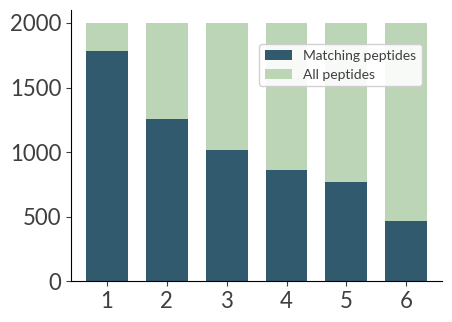

In [ ]:
def _as_list(x):
    if isinstance(x, list): return x
    if isinstance(x, str):
        try:
            v = ast.literal_eval(x)
            if isinstance(v, (list, tuple)): return list(v)
        except Exception:
            return [t.strip() for t in x.split(",") if t.strip()]
    return [] if pd.isna(x) else []

def _row_success(row):
    used = [f for f in FEATURES if f in set(_as_list(row.get("used_features", [])))]
    if not used:
        return False
    if "match_all_targeted" in row and not pd.isna(row["match_all_targeted"]):
        return bool(row["match_all_targeted"])
    for f in used:
        v = row.get(f"match_"+f, pd.NA)
        if pd.isna(v) or not bool(v):
            return False
    return True

def _count_k(u):
    used = set(_as_list(u))
    return sum(f in used for f in COUNT_FEATURES)

tmp = results['samples_df'].copy()
tmp = tmp[tmp["ood_type"] == "in_dist"].copy()
tmp["k"] = tmp["used_features"].apply(_count_k)
tmp["success"] = tmp.apply(_row_success, axis=1)

plot_df = (tmp[tmp["k"] > 0]
           .groupby("k", as_index=False)
           .agg(total=("success","size"), successes=("success","sum")))
plot_df["remainder"] = plot_df["total"] - plot_df["successes"]

max_k = len(COUNT_FEATURES) if len(COUNT_FEATURES) > 0 else plot_df["k"].max()
full_k = np.arange(1, max_k+1, dtype=int)
plot_df = (plot_df.set_index("k")
                  .reindex(full_k, fill_value=0)
                  .rename_axis("k").reset_index())

fig, ax = plt.subplots(figsize=(4.8, 3.5))

x = plot_df["k"].to_numpy()
succ = plot_df["successes"].to_numpy()
rem  = plot_df["remainder"].to_numpy()

SUCCESS_COLOR = TEAL[4]
REMAINDER_COLOR = TEAL[0]
BAR_WIDTH = 0.7

ax.bar(x, succ, width=BAR_WIDTH, label="Matching peptides",
       color=SUCCESS_COLOR, alpha=0.9, linewidth=0)

ax.bar(x, rem, width=BAR_WIDTH, bottom=succ, label="All peptides",
       color=REMAINDER_COLOR, alpha=0.9, linewidth=0)

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

ax.set_xticks(full_k)
ax.set_xlim(full_k.min()-0.6, full_k.max()+0.6)

leg = ax.legend(
    loc="upper right",
    bbox_to_anchor=(0.965, 0.9),
    ncol=1,
    frameon=True, fancybox=True, framealpha=0.9, fontsize=10
)

plt.tight_layout()
plt.show()
fig.savefig("conditions_success_stacked.svg", format="svg", bbox_inches="tight", dpi=300)


In [37]:
with open(output_file, 'wb') as f:
    pickle.dump(results, f)
print(f"Results saved to {output_file}")

Results saved to cvae_evaluation_results_new.pkl
